# Symmetrize affinities

This function have the following cost:
* adds: $\frac{N \cdot(N-1)}{2} + N^2$
* divisions: $N^2$
* mults: $N^2$
* total: $\frac{N \cdot(N-1)}{2} + 3N^2$

So:
$$W = \frac{N \cdot(N-1)}{2} + 3N^2 flops$$

The memory traffic is computed taking into account that there is warm cache (on the previous step the whole input matrix have been accessed so it should be in cache):
$$Q = 4 N^2$$

And so the operational intensity is:
$$I \approxeq \frac{7}{8}  \text{flops/byte}$$
The computation will be **memory bound**.


In [10]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from visualization import plot

mpl.rcParams['figure.figsize'] = (8.1, 5)
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.family'] = 'Roboto'
mpl.rcParams['font.size'] = 15

Cache sizes and limits taking into account that the working set is:
$$W_{set} = N^2$$

In [3]:
cache_1 = 32 * 2**10    # 32 KB
cache_2 = 256 * 2**10   # 256 KB
cache_3 = 8 * 2**20.    # 8 MB


N_cache1 = np.sqrt(cache_1 / 4)
N_cache2 = np.sqrt(cache_2 / 4)
N_cache3 = np.sqrt(cache_3 / 4)
print(f"Cache 1 limit size: {N_cache1}")
print(f"Cache 2 limit size: {N_cache2}")
print(f"Cache 3 limit size: {N_cache3}")

Cache 1 limit size: 90.50966799187809
Cache 2 limit size: 256.0
Cache 3 limit size: 1448.1546878700494


# Euler

### System Information

Compiler:
```
icc 16.0.0
```

CPU: **Intel Xeon E3-1285Lv5 Skylake 3.00 GHz**

Cache:
* L1: 32 KB
* L2: 256 KB
* L3: 8 MB

Memory bandwidth: 34.1 GB/s (theoretical)

## Benchmark 1

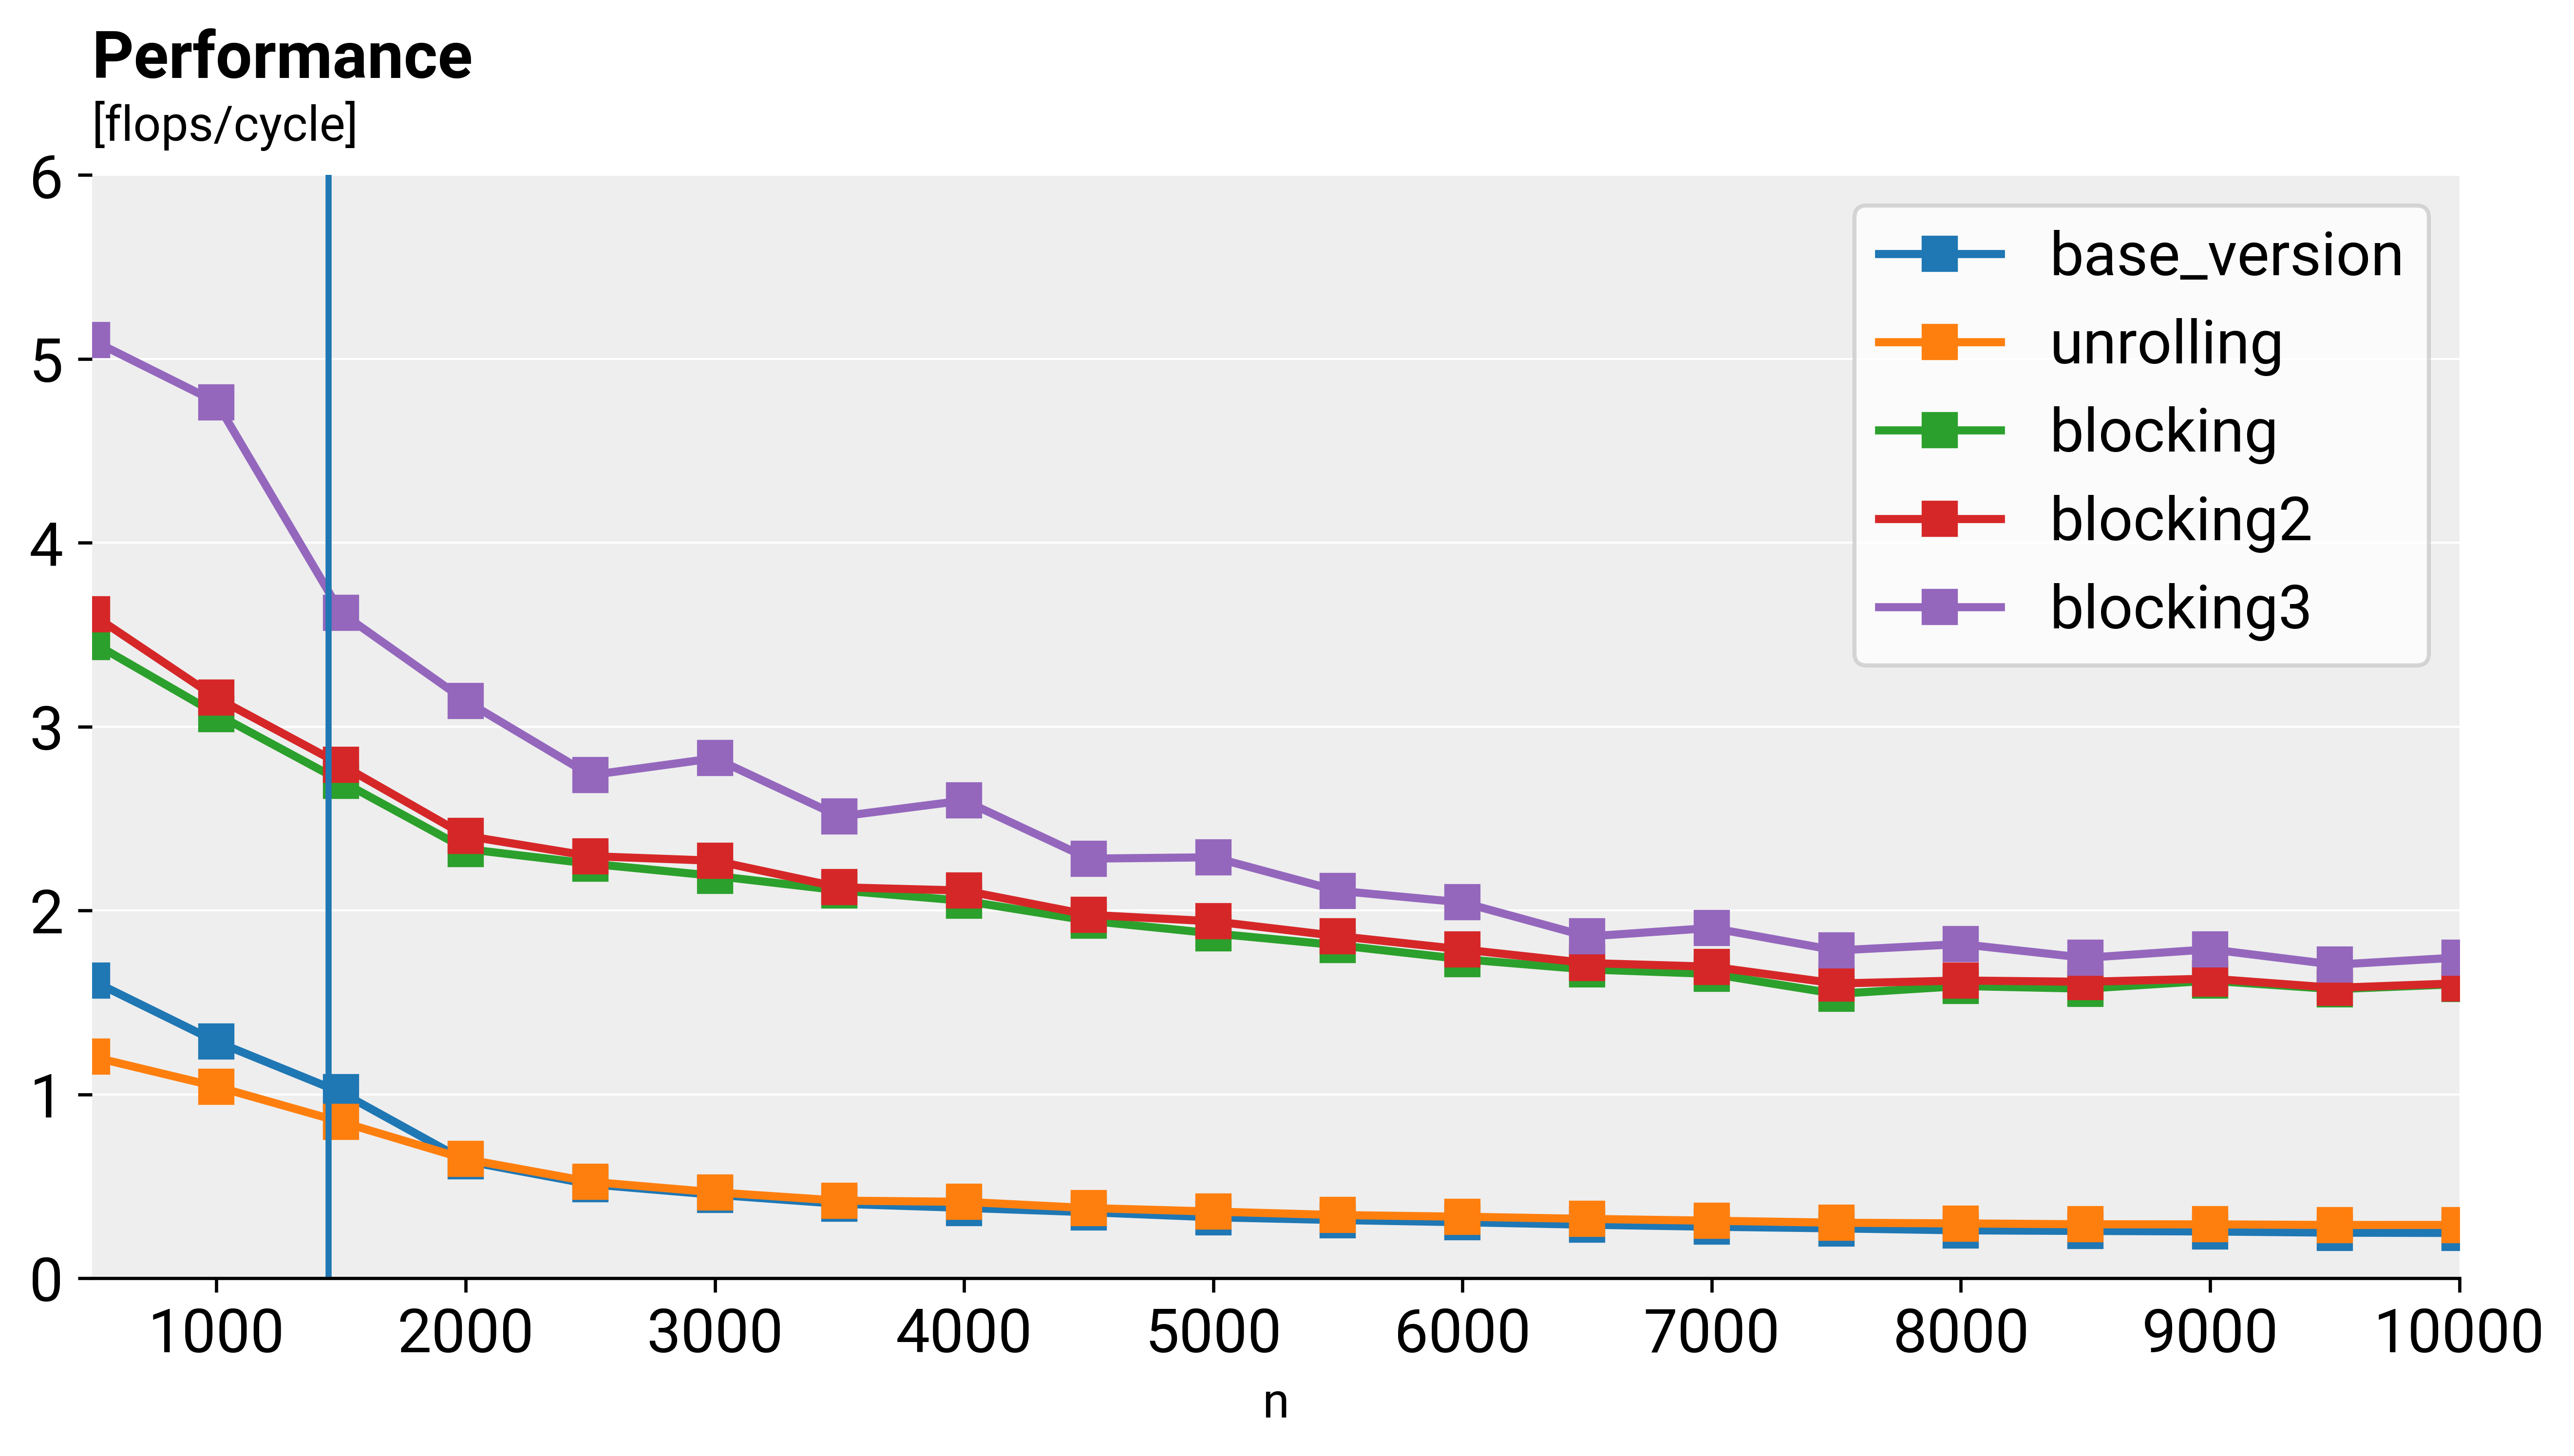

In [7]:
data = pd.read_csv("./bench_euler.csv")
# Extract the input size
N = data["N"].as_matrix()
# Decompose the data frame into the different functions and compute the performance
func_names = data.columns.values[1:]
perf = []
flops = {
    "base_version": N * (N - 1) / 2 + 3*N**2,
    "unrolling": N * (N - 1) / 2 + 3*N**2,
    "blocking": N/8*(N/8-1)*(2*8*8 + 8*8) + 3*N**2,
    "blocking2": N/8*(N/8-1)*(2*8*8 + 8*8) + 3*N**2,
    "blocking3": N/8*(N/8-1)*(2*8*8 + 8*8) + 3*N**2,
}

for func in func_names:
    cycles = data[func].as_matrix()
    P = flops[func] / cycles
    perf.append(P)
perf = np.array(perf)

ax = plot(N, perf, labels=func_names, ylim=6, title="Performance")
n = np.arange(1000, 10000+1, 1000)
ax.set_xticks(n)
ax.set_xticklabels(n)
ax.axvline(N_cache1)
ax.axvline(N_cache2)
ax.axvline(N_cache3)
plt.show()

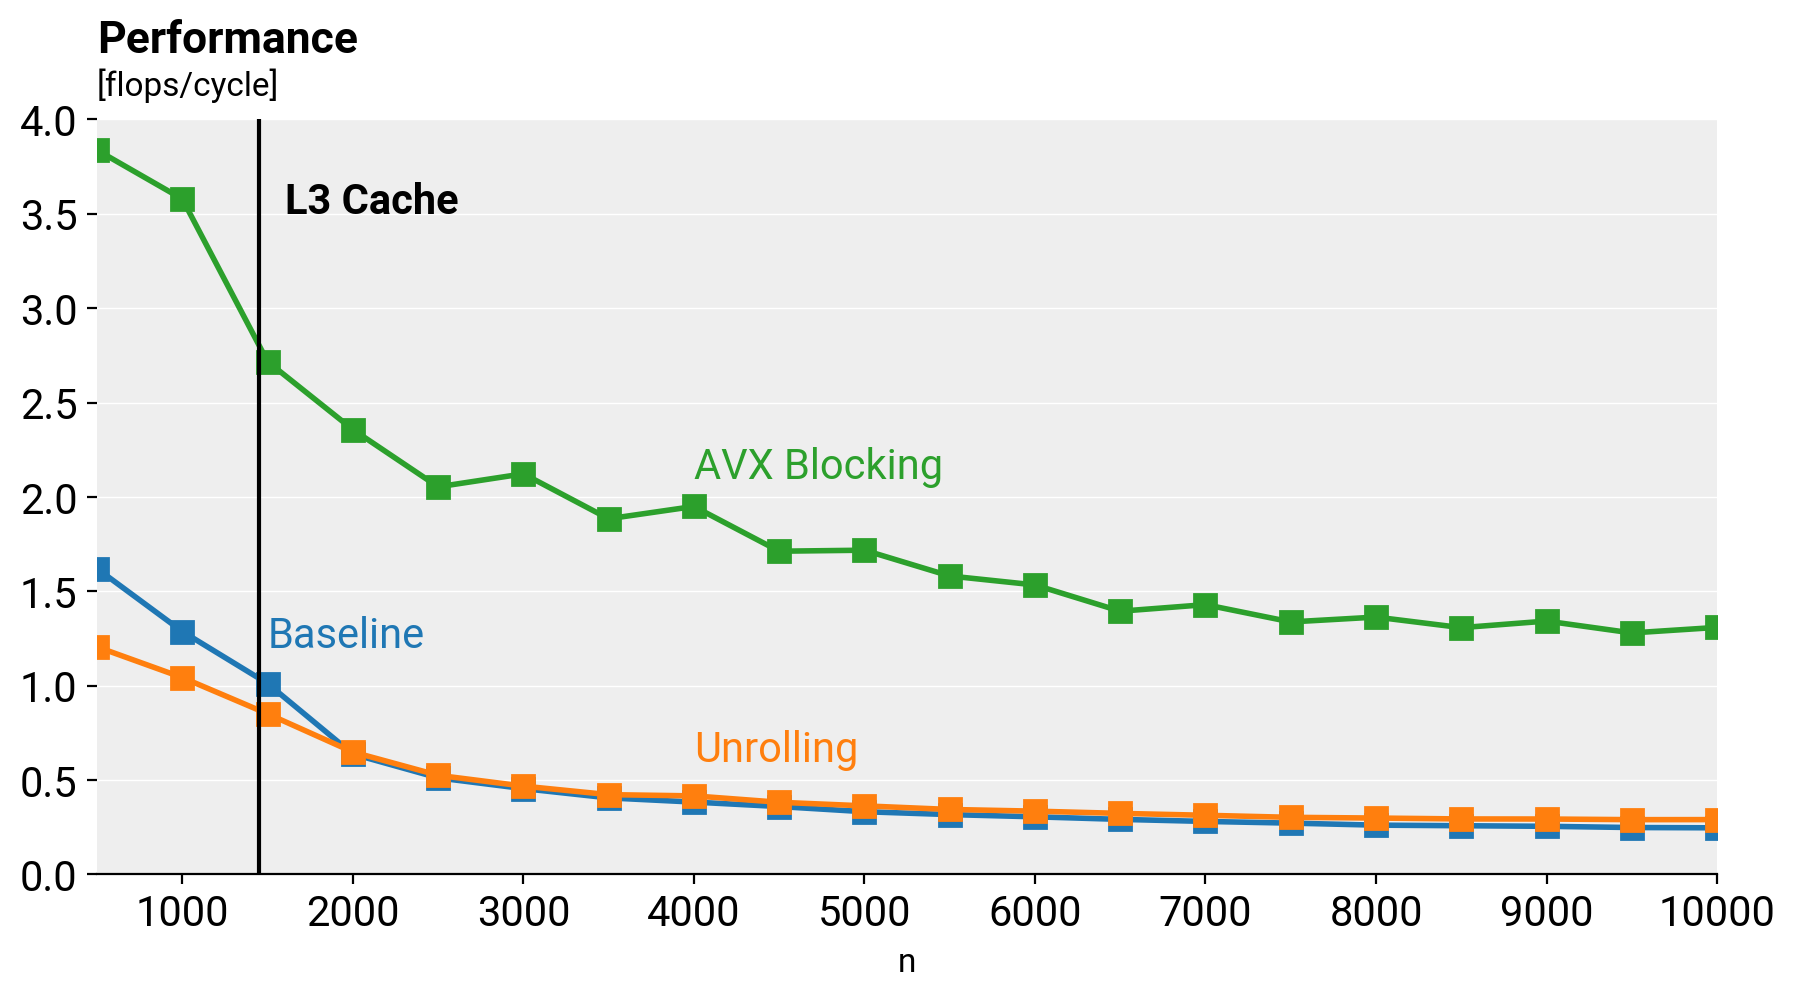

In [16]:
data = pd.read_csv("./bench_euler.csv")
# Extract the input size
N = data["N"].as_matrix()
# Decompose the data frame into the different functions and compute the performance
func_names = data.columns.values[1:]
perf = []
flops = {
    "base_version": N * (N - 1) / 2 + 3*N**2,
    "unrolling": N * (N - 1) / 2 + 3*N**2,
    "blocking": N/8*(N/8-1)*(2*8*8 + 8*8)/2 + 3*N**2,
    "blocking2": N/8*(N/8-1)*(2*8*8 + 8*8)/2 + 3*N**2,
    "blocking3": N/8*(N/8-1)*(2*8*8 + 8*8)/2 + 3*N**2,
}

for func in func_names:
    cycles = data[func].as_matrix()
    P = flops[func] / cycles
    perf.append(P)
perf = np.array(perf)

title = "Performance"
ylabel = "flops/cycle"
legend = False
lw = 2
marker = "s"
markersize = 8
labels_fontsize = 12
fontsize = 20
xlabel = "n"
ylim = 4

fig = plt.figure()
if title:
    fig.suptitle(title, fontweight='bold', fontsize=16, x=0, ha='left')
ax = fig.add_subplot(111)
fig.subplots_adjust(top=.88, left=0, right=1)

base, = ax.plot(N, perf[0], linewidth=lw, marker=marker, markersize=markersize, label="Baseline")
unroll, =ax.plot(N, perf[1], linewidth=lw, marker=marker, markersize=markersize, label="Unrolling")
avx, = ax.plot(N, perf[4], linewidth=lw, marker=marker, markersize=markersize, label="AVX Blocking")

ax.text(1500, 1.2, "Baseline", color=base.get_color())
ax.text(4000, 0.6, "Unrolling", color=unroll.get_color())

ax.text(4000, 2.1, "AVX Blocking", color=avx.get_color())

if legend:
    ax.legend()
ax.set_ylim([0, ylim])

ax.set_xlim([N.min(), N.max()])
ax.set_xlabel(xlabel, fontsize=labels_fontsize)

# For runtime plots where on the yaxis there is an exponent, place the text
# on the axis title
exponent_text = ''
ax.ticklabel_format(axis='y', style='sci')
plt.draw()
if ax.yaxis.get_offset_text().get_text() != '':
    ax.yaxis.major.formatter._useMathText = True
    plt.draw()
    exponent_text = '[{}]'.format(ax.yaxis.get_offset_text().get_text())
    ax.yaxis.offsetText.set_visible(False)

ax.set_title(
    '[{}]{}'.format(ylabel, exponent_text),
    fontsize=labels_fontsize,
    position=(0, 1.0),
    ha='left',
    va='bottom')

ax.yaxis.grid(color='#ffffff', linestyle='-', linewidth=.5)
ax.set_facecolor('#eeeeee')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

ax.set_xticks(np.arange(1000, 10000+1, 1000))
ax.set_xticklabels(np.arange(1000, 10000+1, 1000))
ax.axvline(N_cache3, c="k")
ax.text(1600, 3.5, "L3 Cache", fontweight="bold")

plt.savefig("bench_euler.png", bbox_inches="tight")

plt.show()